## 2.3 Modelamiento I — Calibración de Sensores


In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Ruta al CSV
fp = "../Data/processed/air_quality_UCI_cleaned.csv"

# Cargar dataset
df = pd.read_csv(fp, parse_dates=["DateTime"])

# Asegurar índice temporal
df["DateTime"] = pd.to_datetime(df["DateTime"])
df = df.set_index("DateTime").sort_index()

df_completo = df.copy()

print("Dataframe cargado:", df_completo.shape)
print("Columnas:", df_completo.columns.tolist())


Dataframe cargado: (9357, 18)
Columnas: ['Date', 'Time', 'CO(GT)', 'PT08.S1(CO)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH', 'dia', 'hora', 'mes', 'fin_de_semana']


In [27]:
def modelo_lineal(x, a, b):
    return a * x + b

def ajustar_lineal(x, y, p0=(1.0, 0.0)):

    mask = (~np.isnan(x)) & (~np.isnan(y))
    x1, y1 = x[mask], y[mask]

    if x1.size < 2:
        raise ValueError("Datos insuficientes para ajustar modelo.")

    params, cov = curve_fit(modelo_lineal, x1, y1, p0=p0)
    a, b = params

    y_pred = modelo_lineal(x1, a, b)

    rmse = np.sqrt(np.mean((y1 - y_pred) ** 2))

    ss_res = np.sum((y1 - y_pred) ** 2)
    ss_tot = np.sum((y1 - np.mean(y1)) ** 2)
    r2 = 1 - ss_res / ss_tot if ss_tot > 0 else np.nan

    return {
        "a": a,
        "b": b,
        "cov": cov,
        "rmse": rmse,
        "r2": r2,
        "x": x1,
        "y": y1,
        "y_pred": y_pred
    }


### Modelos univariables (3 sensores)
A continuación se ajustan 3 modelos univariables:
- `PT08.S1(CO)` → `CO(GT)`
- `PT08.S2(NMHC)` → `C6H6(GT)`
- `PT08.S3(NOx)` → `NOx(GT)`

Ajuste PT08.S1(CO) → CO(GT): a=0.005210, b=-3.616710, RMSE=0.8702, R2=0.6305


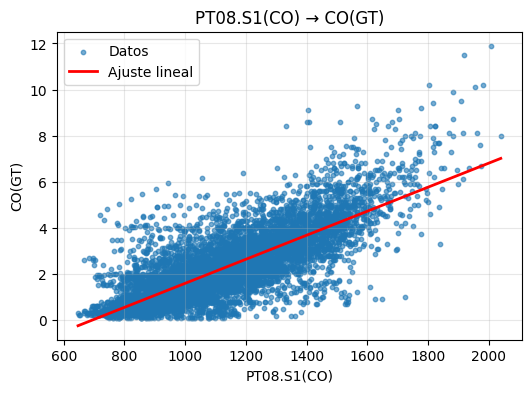

Ajuste PT08.S3(NOx) → NOx(GT): a=-0.500831, b=658.993811, RMSE=159.1875, R2=0.3929


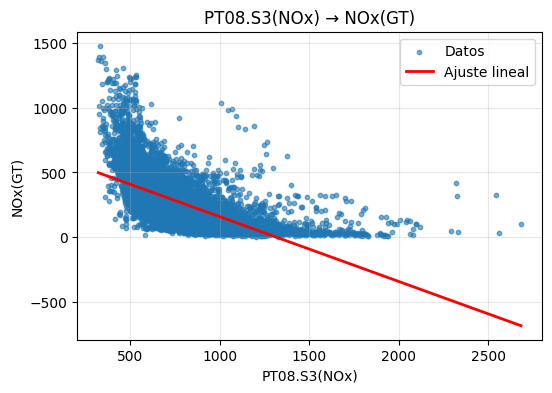

Ajuste PT08.S4(NO2) → NO2(GT): a=0.018168, b=83.228509, RMSE=46.0395, R2=0.0180


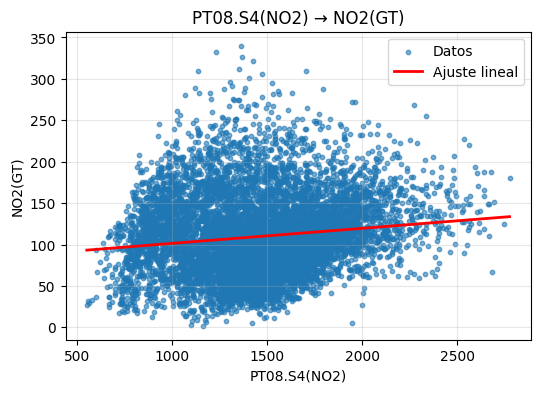

In [32]:
pairs = [
    ('PT08.S1(CO)', 'CO(GT)'),
    ('PT08.S3(NOx)', 'NOx(GT)'),
    ('PT08.S4(NO2)', 'NO2(GT)')
]

results_uni = {}
for xcol, ycol in pairs:
    if xcol not in df_completo.columns or ycol not in df_completo.columns:
        print(f"Advertencia: {xcol} o {ycol} no existe en el df, salto.")
        continue
    x = df_completo[xcol].to_numpy()
    y = df_completo[ycol].to_numpy()
    try:
        res = ajustar_lineal(x, y)
    except Exception as e:
        print(f"Fallo ajuste {xcol} → {ycol}: {e}")
        continue
    results_uni[(xcol, ycol)] = res
    print(f"Ajuste {xcol} → {ycol}: a={res['a']:.6f}, b={res['b']:.6f}, RMSE={res['rmse']:.4f}, R2={res['r2']:.4f}")
    plt.figure(figsize=(6,4))
    plt.scatter(res['x'], res['y'], s=10, alpha=0.6, label='Datos')
    xx = np.linspace(res['x'].min(), res['x'].max(), 200)
    plt.plot(xx, modelo_lineal(xx, res['a'], res['b']), 'r-', lw=2, label='Ajuste lineal')
    plt.xlabel(xcol); plt.ylabel(ycol)
    plt.title(f'{xcol} → {ycol}')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()


### Modelo multivariable para `CO(GT)`
Regresión lineal por mínimos cuadrados con predictores: `PT08.S1(CO)`, `T`, `RH`, `AH`

Multivariable CO(GT) ~ ['PT08.S1(CO)', 'T', 'RH', 'AH']
Betas: {'PT08.S1(CO)': np.float64(0.005256990250685676), 'T': np.float64(-0.008435730409983314), 'RH': np.float64(-0.005176663180991868), 'AH': np.float64(0.0534959310891989)}
Intercept: -3.314257758830722
RMSE=0.8683, R²=0.6322


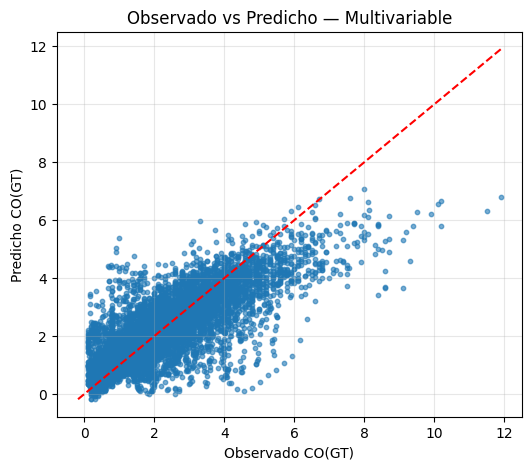

In [29]:
predictors = ['PT08.S1(CO)', 'T', 'RH', 'AH']
target = 'CO(GT)'

# Verificar existencia de columnas y preparar df
cols_mv = [c for c in predictors + [target] if c in df_completo.columns]
if target not in cols_mv or not set(predictors).intersection(df_completo.columns):
    print("Faltan predictores o target; revisa las columnas.")
else:
    df_mv = df_completo[cols_mv].dropna()
    X = df_mv[predictors].to_numpy()
    # Diseño con intercepto
    X_design = np.hstack([X, np.ones((X.shape[0], 1))])
    y = df_mv[target].to_numpy()
    # Ajuste por np.linalg.lstsq
    coeffs, *_ = np.linalg.lstsq(X_design, y, rcond=None)
    betas = coeffs[:-1]
    intercept = coeffs[-1]
    y_pred = X_design @ coeffs
    rmse = np.sqrt(np.mean((y - y_pred)**2))
    ss_res = np.sum((y - y_pred)**2)
    r2 = 1 - ss_res / np.sum((y - y.mean())**2)
    print("Multivariable CO(GT) ~", predictors)
    print("Betas:", dict(zip(predictors, betas)))
    print("Intercept:", intercept)
    print(f"RMSE={rmse:.4f}, R²={r2:.4f}")
    # Gráfica observados vs predichos
    plt.figure(figsize=(6,5))
    plt.scatter(y, y_pred, s=10, alpha=0.6)
    mn, mx = min(y.min(), y_pred.min()), max(y.max(), y_pred.max())
    plt.plot([mn,mx], [mn,mx], 'r--')
    plt.xlabel('Observado CO(GT)'); plt.ylabel('Predicho CO(GT)')
    plt.title('Observado vs Predicho — Multivariable')
    plt.grid(alpha=0.3)
    plt.show()

### Análisis de drift (cambio del coeficiente a con el tiempo)
A continuación calculamos la pendiente `a` del ajuste lineal por mes para `PT08.S1(CO)` → `CO(GT)`.

/tmp/ipykernel_3222/1897189010.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = df_completo[[sensor, gt]].dropna().resample('M')


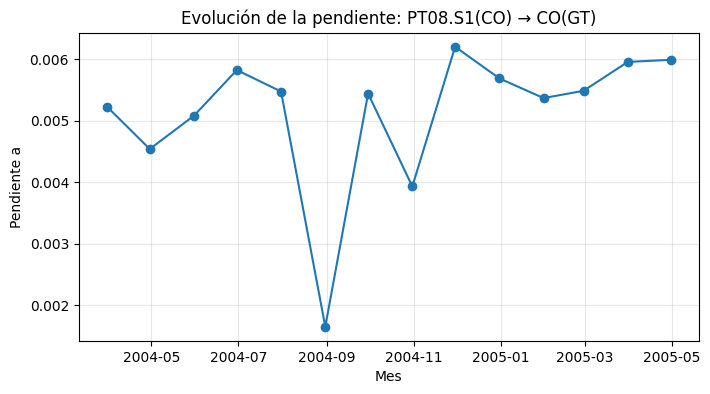

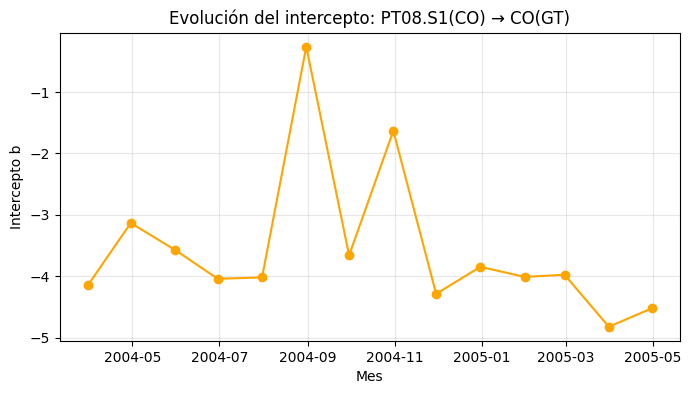

In [31]:
sensor = 'PT08.S1(CO)'
gt = 'CO(GT)'

if sensor in df_completo.columns and gt in df_completo.columns:
    # Resample mensual y ajustar para cada mes si hay suficientes puntos
    slopes = []
    intercepts = []
    idx = []
    monthly = df_completo[[sensor, gt]].dropna().resample('M')
    for period, grp in monthly:
        if len(grp) < 30:
            # opcional: requerir mínimo de puntos por mes
            continue
        x = grp[sensor].to_numpy()
        y = grp[gt].to_numpy()
        try:
            res = ajustar_lineal(x, y)
        except Exception:
            continue
        slopes.append(res['a'])
        intercepts.append(res['b'])
        idx.append(period)

    if slopes:
        plt.figure(figsize=(8,4))
        plt.plot(idx, slopes, '-o', label='Pendiente a (mes)')
        plt.xlabel('Mes')
        plt.ylabel('Pendiente a')
        plt.title(f'Evolución de la pendiente: {sensor} → {gt}')
        plt.grid(alpha=0.3)
        plt.show()

        plt.figure(figsize=(8,4))
        plt.plot(idx, intercepts, '-o', label='Intercepto b (mes)', color='orange')
        plt.xlabel('Mes')
        plt.ylabel('Intercepto b')
        plt.title(f'Evolución del intercepto: {sensor} → {gt}')
        plt.grid(alpha=0.3)
        plt.show()
    else:
        print("No se obtuvieron suficientes ventanas mensuales con datos para el análisis de drift.")
else:
    print(f"Columnas {sensor} o {gt} no encontradas.")